# P3-Anticipez les besoins en consommation électrique de bâtiments : Modèles prédictifs pour la consommation totale d'énergie

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from math import log
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.dummy import DummyRegressor

## Importation des données 

In [30]:
data = pd.read_csv("data_nett.csv")

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3231 entries, 0 to 3230
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   CouncilDistrictCode              3231 non-null   int64  
 1   YearBuilt                        3231 non-null   float64
 2   NumberofBuildings                3231 non-null   float64
 3   NumberofFloors                   3231 non-null   float64
 4   PropertyGFATotal                 3231 non-null   float64
 5   PropertyGFAParking               3231 non-null   float64
 6   PropertyGFABuilding(s)           3231 non-null   float64
 7   LargestPropertyUseTypeGFA        3231 non-null   float64
 8   SecondLargestPropertyUseTypeGFA  3231 non-null   float64
 9   ThirdLargestPropertyUseTypeGFA   3231 non-null   float64
 10  ENERGYSTARScore                  3231 non-null   float64
 11  SiteEnergyUse(kBtu)              3231 non-null   float64
 12  TotalGHGEmissions   

In [32]:
data.isna().mean()

CouncilDistrictCode                0.000000
YearBuilt                          0.000000
NumberofBuildings                  0.000000
NumberofFloors                     0.000000
PropertyGFATotal                   0.000000
PropertyGFAParking                 0.000000
PropertyGFABuilding(s)             0.000000
LargestPropertyUseTypeGFA          0.000000
SecondLargestPropertyUseTypeGFA    0.000000
ThirdLargestPropertyUseTypeGFA     0.000000
ENERGYSTARScore                    0.000000
SiteEnergyUse(kBtu)                0.000000
TotalGHGEmissions                  0.000000
ZipCode                            0.000000
Latitude                           0.000000
Longitude                          0.000000
BuildingType                       0.000000
PrimaryPropertyType                0.000000
Neighborhood                       0.000000
LargestPropertyUseType             0.021975
SecondLargestPropertyUseType       0.493036
ThirdLargestPropertyUseType        0.790158
dtype: float64

In [33]:
data['LargestPropertyUseType'] = data['LargestPropertyUseType'].astype(str)
data['SecondLargestPropertyUseType'] = data['SecondLargestPropertyUseType'].astype(str)
data['ThirdLargestPropertyUseType'] = data['ThirdLargestPropertyUseType'].astype(str)

In [34]:
data.isna().mean()

CouncilDistrictCode                0.0
YearBuilt                          0.0
NumberofBuildings                  0.0
NumberofFloors                     0.0
PropertyGFATotal                   0.0
PropertyGFAParking                 0.0
PropertyGFABuilding(s)             0.0
LargestPropertyUseTypeGFA          0.0
SecondLargestPropertyUseTypeGFA    0.0
ThirdLargestPropertyUseTypeGFA     0.0
ENERGYSTARScore                    0.0
SiteEnergyUse(kBtu)                0.0
TotalGHGEmissions                  0.0
ZipCode                            0.0
Latitude                           0.0
Longitude                          0.0
BuildingType                       0.0
PrimaryPropertyType                0.0
Neighborhood                       0.0
LargestPropertyUseType             0.0
SecondLargestPropertyUseType       0.0
ThirdLargestPropertyUseType        0.0
dtype: float64

In [35]:
print(data.shape)
data = data.drop(['TotalGHGEmissions'], axis=1)
print(data.shape)

(3231, 22)
(3231, 21)


<AxesSubplot:>

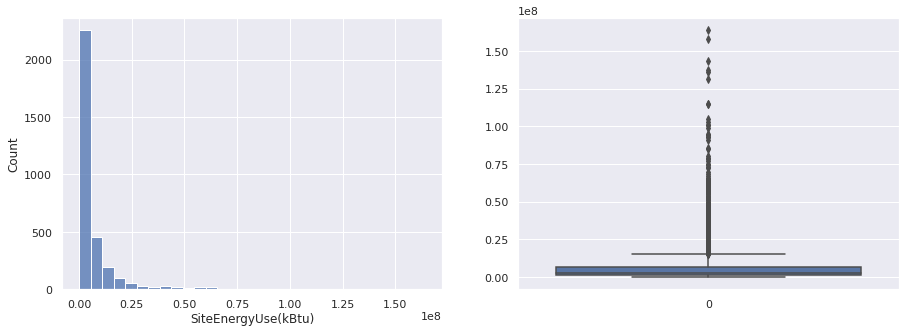

In [36]:
#Pour rappel : Histogramme de distribution et boxplot'

var = 'SiteEnergyUse(kBtu)'

sns.set(rc = {'figure.figsize':(15,5)})
fig, (ax1, ax2) = plt.subplots(1,2)
sns.histplot(data, x=var, bins=30, ax=ax1)
sns.boxplot(data = data[var], ax=ax2)

In [37]:
data['SiteEnergyUse(kBtu)'].describe()

count    3.231000e+03
mean     7.201475e+06
std      1.362199e+07
min      0.000000e+00
25%      1.243047e+06
50%      2.553764e+06
75%      6.926601e+06
max      1.639460e+08
Name: SiteEnergyUse(kBtu), dtype: float64

## Data Preprocessing 

In [38]:
#Définition des variables X et de la target y

X = data.drop(['SiteEnergyUse(kBtu)'], axis=1)
y = data['SiteEnergyUse(kBtu)']

In [39]:
print(X.shape)
print(y.shape)

(3231, 20)
(3231,)


In [40]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3231 entries, 0 to 3230
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   CouncilDistrictCode              3231 non-null   int64  
 1   YearBuilt                        3231 non-null   float64
 2   NumberofBuildings                3231 non-null   float64
 3   NumberofFloors                   3231 non-null   float64
 4   PropertyGFATotal                 3231 non-null   float64
 5   PropertyGFAParking               3231 non-null   float64
 6   PropertyGFABuilding(s)           3231 non-null   float64
 7   LargestPropertyUseTypeGFA        3231 non-null   float64
 8   SecondLargestPropertyUseTypeGFA  3231 non-null   float64
 9   ThirdLargestPropertyUseTypeGFA   3231 non-null   float64
 10  ENERGYSTARScore                  3231 non-null   float64
 11  ZipCode                          3231 non-null   int64  
 12  Latitude            

In [41]:
#Encodage des variables qualitatives

encoder = LabelEncoder()

X['BuildingType'] = encoder.fit_transform(X['BuildingType'])
X['PrimaryPropertyType'] = encoder.fit_transform(X['PrimaryPropertyType'])
X['Neighborhood'] = encoder.fit_transform(X['Neighborhood'])
X['LargestPropertyUseType'] = encoder.fit_transform(X['LargestPropertyUseType'])
X['SecondLargestPropertyUseType'] = encoder.fit_transform(X['SecondLargestPropertyUseType'])
X['ThirdLargestPropertyUseType'] = encoder.fit_transform(X['ThirdLargestPropertyUseType'])

In [42]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3231 entries, 0 to 3230
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   CouncilDistrictCode              3231 non-null   int64  
 1   YearBuilt                        3231 non-null   float64
 2   NumberofBuildings                3231 non-null   float64
 3   NumberofFloors                   3231 non-null   float64
 4   PropertyGFATotal                 3231 non-null   float64
 5   PropertyGFAParking               3231 non-null   float64
 6   PropertyGFABuilding(s)           3231 non-null   float64
 7   LargestPropertyUseTypeGFA        3231 non-null   float64
 8   SecondLargestPropertyUseTypeGFA  3231 non-null   float64
 9   ThirdLargestPropertyUseTypeGFA   3231 non-null   float64
 10  ENERGYSTARScore                  3231 non-null   float64
 11  ZipCode                          3231 non-null   int64  
 12  Latitude            

In [43]:
#Constitution des jeux de données test et train

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2584, 20)
(2584,)
(647, 20)
(647,)


## Constructions des modèles avec optimisation des hyperparamètres

### Ridge Regression

#### Mise en place du modèle 

In [26]:
#Définition des étapes du pipeline

steps = [
    ('scalar', StandardScaler()),  #Standardisation des données d'entrée pour gommer les différences d'échelles
    ('model', Ridge())    #Application du modèle = Regression Ridge
]
ridge_pipe = Pipeline(steps) #Création du pipeline

In [27]:
#Entraînement du modèle sur les données d'apprentissage

ridge_pipe.fit(X_train, y_train)

Pipeline(steps=[('scalar', StandardScaler()), ('model', Ridge())])

#### Optimisation de l'hyperparamètre alpha

In [18]:
#Optimisation de l'hyperparamètre alpha par Grid search sur les données d'apprentissage

parameters = {'model__alpha': np.arange(0, 20, 1)} #Je définie l'étendue de la grille pour les valeurs d'alpha
 
grid_ridge = GridSearchCV(estimator = ridge_pipe, #Optimisation automatique des paramètres selon la grille définie
                           param_grid = parameters,
                           scoring = 'neg_root_mean_squared_error',
                           cv = KFold(5, random_state=0, shuffle=True),
                           n_jobs = -1)
grid_ridge = grid_ridge.fit(X_train, y_train)

In [19]:
grid_ridge.best_params_

{'model__alpha': 19}

In [28]:
#Optimisation de l'hyperparamètre alpha par Grid search sur les données d'apprentissage

parameters = {'model__alpha': np.arange(15, 100, 1)} #Je définie l'étendue de la grille pour les valeurs d'alpha
 
grid_ridge = GridSearchCV(estimator = ridge_pipe, #Optimisation automatique des paramètres selon la grille définie
                           param_grid = parameters,
                           scoring = 'neg_root_mean_squared_error',
                           cv = KFold(5, random_state=0, shuffle=True),
                           n_jobs = -1)
grid_ridge = grid_ridge.fit(X_train, y_train)

In [29]:
#Meilleure valeur pour alpha
alpha_opt = grid_ridge.best_params_['model__alpha']
print(alpha_opt)

99


In [34]:
#Optimisation de l'hyperparamètre alpha par Grid search sur les données d'apprentissage

parameters = {'model__alpha': np.arange(100, 1500, 10)} #Je définie l'étendue de la grille pour les valeurs d'alpha
 
grid_ridge = GridSearchCV(estimator = ridge_pipe, #Optimisation automatique des paramètres selon la grille définie
                           param_grid = parameters,
                           scoring = 'neg_root_mean_squared_error',
                           cv = KFold(5, random_state=0, shuffle=True),
                           n_jobs = -1)
grid_ridge = grid_ridge.fit(X_train, y_train)

In [35]:
#Meilleure valeur pour alpha
alpha_opt = grid_ridge.best_params_['model__alpha']
print(alpha_opt)

1030


In [36]:
#Optimisation de l'hyperparamètre alpha par Grid search sur les données d'apprentissage

parameters = {'model__alpha': np.arange(1000, 1045, 1)} #Je définie l'étendue de la grille pour les valeurs d'alpha
 
grid_ridge = GridSearchCV(estimator = ridge_pipe, #Optimisation automatique des paramètres selon la grille définie
                           param_grid = parameters,
                           scoring = 'neg_root_mean_squared_error',
                           cv = KFold(5, random_state=0, shuffle=True),
                           n_jobs = -1)
grid_ridge = grid_ridge.fit(X_train, y_train)

In [37]:
#Meilleure valeur pour alpha
alpha_opt = grid_ridge.best_params_['model__alpha']
print(alpha_opt)

1034


In [38]:
#Valeur de score la plus basse
score_ridge = grid_ridge.best_score_
score_ridge = round(score_ridge)
print(score_ridge)

-9302215


In [39]:
#Meilleur modèle
grid_ridge.best_estimator_

Pipeline(steps=[('scalar', StandardScaler()), ('model', Ridge(alpha=1034))])

#### Evaluation de la cross validation

In [40]:
#Relance de la Grid Search en cross validation avec l'alpha optimal et le R2 score

parameters = {'model__alpha': [alpha_opt] }
 
grid_ridge_opt = GridSearchCV(estimator = ridge_pipe,
                           param_grid = parameters,
                           scoring = 'r2',
                           cv = KFold(5, random_state=0, shuffle=True),
                           n_jobs = -1)
grid_ridge_opt = grid_ridge_opt.fit(X_train, y_train)

In [41]:
#Valeur du R2
R2_ridge = round(grid_ridge_opt.best_score_,3)
print(R2_ridge)

0.482


### Modèle : Random Forest

#### Mise en place du modèle

In [42]:
#Définition des étapes du pipeline

steps = [
    ('scalar', StandardScaler()),  #Standardisation des données d'entrée pour gommer les différences d'échelles
    ('model', RandomForestRegressor(random_state = 0))    #Application du modèle = random_forest
]
random_pipe = Pipeline(steps) #Création du pipeline

In [43]:
#Entraînement du modèle sur les données d'apprentissage

random_pipe.fit(X_train, y_train)

Pipeline(steps=[('scalar', StandardScaler()),
                ('model', RandomForestRegressor(random_state=0))])

#### Optimisation des hyperparamètres

In [44]:
parameters = {
    'model__n_estimators' : np.arange(1,100,10),
    'model__max_features' : np.arange(0.1,0.9, 0.1),
    'model__min_samples_split' : np.arange(1,10,1),
    'model__max_depth' : np.arange(1,20,2)
    }

In [45]:
grid_random = GridSearchCV(estimator = random_pipe,
                        param_grid = parameters,
                        scoring='neg_root_mean_squared_error',
                        cv=KFold(5, random_state=0, shuffle=True),
                        n_jobs=-1
                          )

In [46]:
grid_random.fit(X_train,y_train)

/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
4000 fits failed out of a total of 36000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4000 fits failed with the following error:
Traceback (most recent call last):
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/ensem

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('model',
                                        RandomForestRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model__max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                         'model__max_features': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                         'model__min_samples_split': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'model__n_estimators': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91])},
             scoring='neg_root_mean_squared_error')

In [47]:
grid_random.best_params_

{'model__max_depth': 17,
 'model__max_features': 0.6,
 'model__min_samples_split': 6,
 'model__n_estimators': 11}

In [48]:
score_random = grid_random.best_score_
score_random = round(score_random)
print(score_random)

-5204498


In [51]:
parameters = {
    'model__n_estimators' : np.arange(1,22,1),
    'model__max_features' : np.arange(0.1,0.9, 0.1),
    'model__min_samples_split' : np.arange(1,10,1),
    'model__max_depth' : np.arange(14,22,1)
    }

In [52]:
grid_random = GridSearchCV(estimator = random_pipe,
                        param_grid = parameters,
                        scoring='neg_root_mean_squared_error',
                        cv=KFold(5, random_state=0, shuffle=True),
                        n_jobs=-1
                          )

In [53]:
grid_random.fit(X_train,y_train)

/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
6720 fits failed out of a total of 60480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6720 fits failed with the following error:
Traceback (most recent call last):
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/ensem

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('model',
                                        RandomForestRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model__max_depth': array([14, 15, 16, 17, 18, 19, 20, 21]),
                         'model__max_features': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                         'model__min_samples_split': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'model__n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21])},
             scoring='neg_root_mean_squared_error')

In [54]:
grid_random.best_params_

{'model__max_depth': 20,
 'model__max_features': 0.4,
 'model__min_samples_split': 4,
 'model__n_estimators': 10}

In [55]:
score_random = grid_random.best_score_
score_random = round(score_random)
print(score_random)

-5105747


In [59]:
max_depth_opt = grid_random.best_params_['model__max_depth']
print(max_depth_opt)

20


In [60]:
max_features_opt = grid_random.best_params_['model__max_features']
print(max_features_opt)

0.4


In [61]:
min_samples_split_opt = grid_random.best_params_['model__min_samples_split']
print(min_samples_split_opt)

4


In [62]:
n_estimators_opt = grid_random.best_params_['model__n_estimators']
print(n_estimators_opt)

10


In [56]:
grid_random.best_estimator_

Pipeline(steps=[('scalar', StandardScaler()),
                ('model',
                 RandomForestRegressor(max_depth=20, max_features=0.4,
                                       min_samples_split=4, n_estimators=10,
                                       random_state=0))])

Text(0.5, 0, 'Relative Importance')

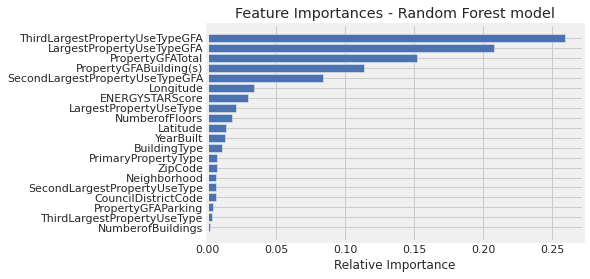

In [126]:
importances = grid_random.best_estimator_['model'].feature_importances_
indices = np.argsort(importances)
liste_variables = list(X.columns)

# style du graphique 
plt.style.use('fivethirtyeight')
%matplotlib inline

plt.figure(1)
plt.title('Feature Importances - Random Forest model')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [liste_variables[i] for i in indices])
plt.xlabel('Relative Importance')

#### Evaluation de la cross validation

In [67]:
parameters_opt = {
    'model__n_estimators' : [n_estimators_opt],
    'model__max_features' : [max_features_opt],
    'model__min_samples_split' : [min_samples_split_opt],
    'model__max_depth' : [max_depth_opt]
    }

In [70]:
grid_random_opt = GridSearchCV(estimator = random_pipe,
                        param_grid = parameters_opt,
                        scoring='r2',
                        cv=KFold(5, random_state=0, shuffle=True),
                        n_jobs=-1
                          )

In [71]:
grid_random_opt.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('model',
                                        RandomForestRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [20], 'model__max_features': [0.4],
                         'model__min_samples_split': [4],
                         'model__n_estimators': [10]},
             scoring='r2')

In [72]:
R2_random = round(grid_random_opt.best_score_,3)
print(R2_random)

0.857


### Modèle : Gradient Boosting

#### Mise en place du modèle

In [74]:
#Définition des étapes du pipeline

steps = [
    ('scalar', StandardScaler()),  #Standardisation des données d'entrée pour gommer les différences d'échelles
    ('model_boost', GradientBoostingRegressor(random_state = 0))    #Application du modèle = random_forest
]
boost_pipe = Pipeline(steps) #Création du pipeline

In [75]:
#Entraînement du modèle sur les données d'apprentissage

boost_pipe.fit(X_train, y_train)

Pipeline(steps=[('scalar', StandardScaler()),
                ('model_boost', GradientBoostingRegressor(random_state=0))])

In [85]:
parameters = {
    'model_boost__n_estimators' : np.arange(1,20,5),
    'model_boost__learning_rate' : np.arange(0.1,1, 0.1),
    'model_boost__min_samples_split' : np.arange(1,50,5),
    'model_boost__max_depth' : np.arange(1,20,2)
}

In [86]:
grid_boost = GridSearchCV(estimator = boost_pipe,
                        param_grid = parameters,
                        scoring='neg_root_mean_squared_error',
                        cv=KFold(5, random_state=0, shuffle=True),
                        n_jobs=-1
                          )

In [87]:
grid_boost.fit(X_train,y_train)

/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1800 fits failed out of a total of 18000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1800 fits failed with the following error:
Traceback (most recent call last):
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/ensem

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('model_boost',
                                        GradientBoostingRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model_boost__learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'model_boost__max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                         'model_boost__min_samples_split': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46]),
                         'model_boost__n_estimators': array([ 1,  6, 11, 16])},
             scoring='neg_root_mean_squared_error')

In [88]:
grid_boost.best_params_

{'model_boost__learning_rate': 0.4,
 'model_boost__max_depth': 13,
 'model_boost__min_samples_split': 31,
 'model_boost__n_estimators': 16}

In [89]:
score_boost = grid_boost.best_score_
score_boost = round(score_boost)
print(score_boost)

-5021189


In [95]:
parameters = {
    'model_boost__n_estimators' : np.arange(1,50,5),
    'model_boost__learning_rate' : np.arange(0.1,1, 0.1),
    'model_boost__min_samples_split' : np.arange(1,50,5),
    'model_boost__max_depth' : np.arange(1,20,2)
}

In [96]:
grid_boost = GridSearchCV(estimator = boost_pipe,
                        param_grid = parameters,
                        scoring='neg_root_mean_squared_error',
                        cv=KFold(5, random_state=0, shuffle=True),
                        n_jobs=-1
                          )

In [97]:
grid_boost.fit(X_train,y_train)

/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
4500 fits failed out of a total of 45000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4500 fits failed with the following error:
Traceback (most recent call last):
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/ensem

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('model_boost',
                                        GradientBoostingRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model_boost__learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'model_boost__max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                         'model_boost__min_samples_split': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46]),
                         'model_boost__n_estimators': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46])},
             scoring='neg_root_mean_squared_error')

In [98]:
grid_boost.best_params_

{'model_boost__learning_rate': 0.30000000000000004,
 'model_boost__max_depth': 7,
 'model_boost__min_samples_split': 41,
 'model_boost__n_estimators': 46}

In [99]:
score_boost = grid_boost.best_score_
score_boost = round(score_boost)
print(score_boost)

-4793789


In [100]:
parameters = {
    'model_boost__n_estimators' : np.arange(50,200,50),
    'model_boost__learning_rate' : np.arange(0.1,0.5, 0.1),
    'model_boost__min_samples_split' : np.arange(30,50,5),
    'model_boost__max_depth' : np.arange(1,10,2)
}

In [101]:
grid_boost = GridSearchCV(estimator = boost_pipe,
                        param_grid = parameters,
                        scoring='neg_root_mean_squared_error',
                        cv=KFold(5, random_state=0, shuffle=True),
                        n_jobs=-1
                          )

In [102]:
grid_boost.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('model_boost',
                                        GradientBoostingRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model_boost__learning_rate': array([0.1, 0.2, 0.3, 0.4]),
                         'model_boost__max_depth': array([1, 3, 5, 7, 9]),
                         'model_boost__min_samples_split': array([30, 35, 40, 45]),
                         'model_boost__n_estimators': array([ 50, 100, 150])},
             scoring='neg_root_mean_squared_error')

In [103]:
grid_boost.best_params_

{'model_boost__learning_rate': 0.30000000000000004,
 'model_boost__max_depth': 7,
 'model_boost__min_samples_split': 35,
 'model_boost__n_estimators': 150}

In [104]:
score_boost = grid_boost.best_score_
score_boost = round(score_boost)
print(score_boost)

-4692834


In [105]:
parameters = {
    'model_boost__n_estimators' : np.arange(150,600,50),
    'model_boost__learning_rate' : np.arange(0.1,0.5, 0.1),
    'model_boost__min_samples_split' : np.arange(30,50,5),
    'model_boost__max_depth' : np.arange(1,10,2)
}

In [106]:
grid_boost = GridSearchCV(estimator = boost_pipe,
                        param_grid = parameters,
                        scoring='neg_root_mean_squared_error',
                        cv=KFold(5, random_state=0, shuffle=True),
                        n_jobs=-1
                          )

In [107]:
grid_boost.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('model_boost',
                                        GradientBoostingRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model_boost__learning_rate': array([0.1, 0.2, 0.3, 0.4]),
                         'model_boost__max_depth': array([1, 3, 5, 7, 9]),
                         'model_boost__min_samples_split': array([30, 35, 40, 45]),
                         'model_boost__n_estimators': array([150, 200, 250, 300, 350, 400, 450, 500, 550])},
             scoring='neg_root_mean_squared_error')

In [108]:
grid_boost.best_params_

{'model_boost__learning_rate': 0.30000000000000004,
 'model_boost__max_depth': 7,
 'model_boost__min_samples_split': 35,
 'model_boost__n_estimators': 450}

In [109]:
score_boost = grid_boost.best_score_
score_boost = round(score_boost)
print(score_boost)

-4684693


In [110]:
parameters = {
    'model_boost__n_estimators' : np.arange(400,500,10),
    'model_boost__learning_rate' : np.arange(0.2,0.4, 0.05),
    'model_boost__min_samples_split' : np.arange(30,40,1),
    'model_boost__max_depth' : np.arange(5,10,1)
}

In [111]:
grid_boost = GridSearchCV(estimator = boost_pipe,
                        param_grid = parameters,
                        scoring='neg_root_mean_squared_error',
                        cv=KFold(5, random_state=0, shuffle=True),
                        n_jobs=-1
                          )

In [112]:
grid_boost.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('model_boost',
                                        GradientBoostingRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model_boost__learning_rate': array([0.2 , 0.25, 0.3 , 0.35]),
                         'model_boost__max_depth': array([5, 6, 7, 8, 9]),
                         'model_boost__min_samples_split': array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39]),
                         'model_boost__n_estimators': array([400, 410, 420, 430, 440, 450, 460, 470, 480, 490])},
             scoring='neg_root_mean_squared_error')

In [113]:
grid_boost.best_params_

{'model_boost__learning_rate': 0.35,
 'model_boost__max_depth': 6,
 'model_boost__min_samples_split': 34,
 'model_boost__n_estimators': 450}

In [114]:
score_boost = grid_boost.best_score_
score_boost = round(score_boost)
print(score_boost)

-4683543


In [117]:
learning_rate_boost_opt = grid_boost.best_params_['model_boost__learning_rate']
print(learning_rate_boost_opt)

0.35


In [120]:
max_depth_boost_opt = grid_boost.best_params_['model_boost__max_depth']
print(max_depth_boost_opt)

6


In [121]:
min_samples_split_boost_opt = grid_boost.best_params_['model_boost__min_samples_split']
print(min_samples_split_boost_opt)

34


In [122]:
n_estimators_boost_opt = grid_boost.best_params_['model_boost__n_estimators']
print(n_estimators_boost_opt)

450


In [115]:
grid_boost.best_estimator_

Pipeline(steps=[('scalar', StandardScaler()),
                ('model_boost',
                 GradientBoostingRegressor(learning_rate=0.35, max_depth=6,
                                           min_samples_split=34,
                                           n_estimators=450, random_state=0))])

Text(0.5, 0, 'Relative Importance')

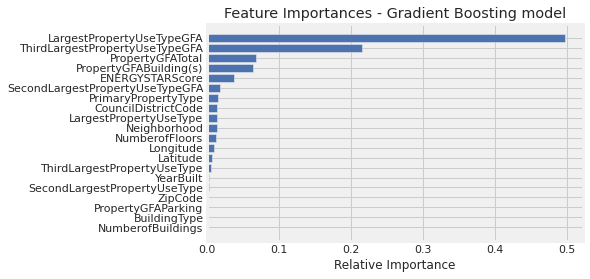

In [127]:
importances = grid_boost.best_estimator_['model_boost'].feature_importances_
indices = np.argsort(importances)
liste_variables = list(X.columns)

# style du graphique 
plt.style.use('fivethirtyeight')
%matplotlib inline

plt.figure(1)
plt.title('Feature Importances - Gradient Boosting model')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [liste_variables[i] for i in indices])
plt.xlabel('Relative Importance')

#### Evaluation de la cross validation

In [136]:
parameters_opt = {
    'model_boost__n_estimators' : [n_estimators_boost_opt],
    'model_boost__learning_rate' : [learning_rate_boost_opt],
    'model_boost__min_samples_split' : [min_samples_split_boost_opt],
    'model_boost__max_depth' : [max_depth_boost_opt]
}

In [137]:
grid_boost_opt = GridSearchCV(estimator = boost_pipe,
                        param_grid = parameters_opt,
                        scoring='r2',
                        cv=KFold(5, random_state=0, shuffle=True),
                        n_jobs=-1
                          )

In [138]:
grid_boost_opt.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('model_boost',
                                        GradientBoostingRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model_boost__learning_rate': [0.35],
                         'model_boost__max_depth': [6],
                         'model_boost__min_samples_split': [34],
                         'model_boost__n_estimators': [450]},
             scoring='r2')

In [139]:
R2_boost = round(grid_boost_opt.best_score_,3)
print(R2_boost)

0.882


## Choix du meilleur modèle

In [140]:
results = pd.DataFrame({
    'Ridge_regression' : [grid_ridge.best_estimator_, score_ridge, R2_ridge],
    'Random Forest' : [grid_random.best_estimator_, score_random, R2_random],
    'Gradient Boosting' : [grid_boost.best_estimator_, score_boost, R2_boost]
}, index = ['Best estimator', 'Grid search error score', 'R2 score'])

In [141]:
results

,Ridge_regression,Random Forest,Gradient Boosting
Best estimator,"(StandardScaler(), Ridge(alpha=1034))","(StandardScaler(), (DecisionTreeRegressor(max_...","(StandardScaler(), ([DecisionTreeRegressor(cri..."
Grid search error score,-9302215,-5105747,-4683543
R2 score,0.482,0.857,0.882


## Prédiction

### Baseline

In [28]:
#Définition des étapes du pipeline

steps = [
    ('scalar', StandardScaler()),  #Standardisation des données d'entrée pour gommer les différences d'échelles
    ('dummy_regr', DummyRegressor(strategy="mean"))    #Application du modèle
]
dummy_regr_pipe = Pipeline(steps) #Création du pipeline

In [44]:
dummy_regr_pipe.fit(X_train, y_train)

Pipeline(steps=[('scalar', StandardScaler()), ('dummy_regr', DummyRegressor())])

In [45]:
y_pred_dummy = dummy_regr_pipe.predict(X_test)

In [46]:
print('RMSE_dummy : ', np.sqrt(mean_squared_error(y_test,y_pred_dummy)))
print('R2_Score_dummy : ', r2_score(y_test,y_pred_dummy))

RMSE_dummy :  13106457.56421194
R2_Score_dummy :  -3.6856534348927994e-05


### Meilleur modèle

In [142]:
#Prédictions à partir des données tests

y_pred_boost = grid_boost.best_estimator_.predict(X_test)

RMSE_grid :  4905690.073060225
R2_Score_grid :  0.8598976017578565


/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SiteEnergyUse(kBtu)', ylabel='Density'>

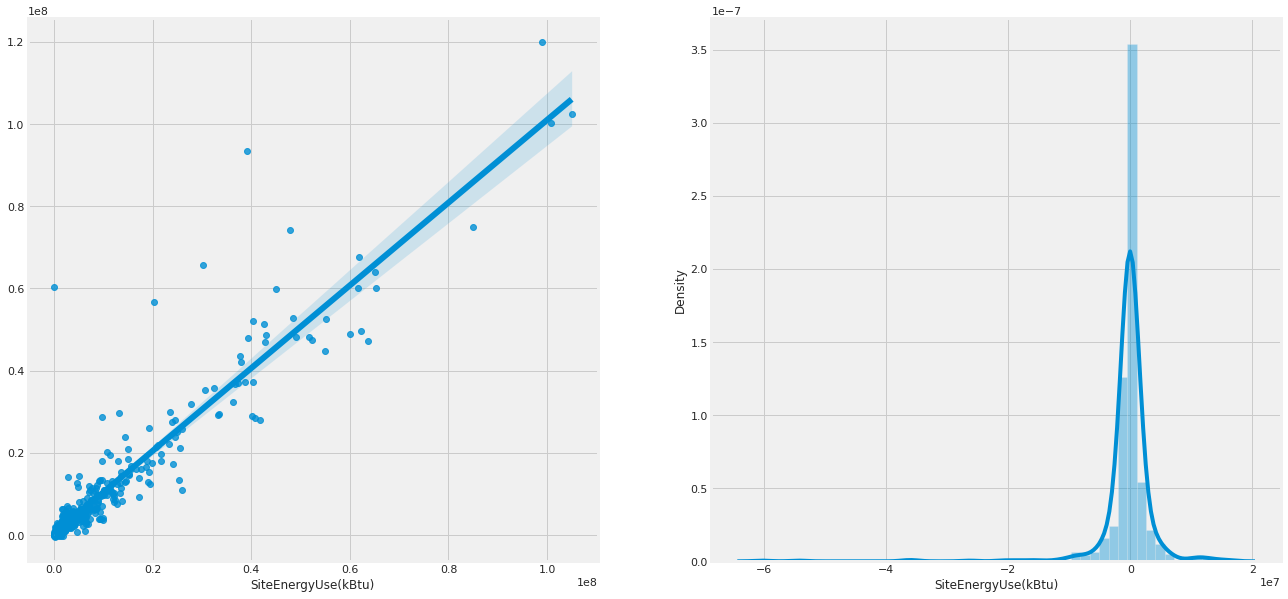

In [145]:
#Evaluation de la prédiction par gradient Boosting

print('RMSE_grid : ', np.sqrt(mean_squared_error(y_test,y_pred_boost)))
print('R2_Score_grid : ', r2_score(y_test,y_pred_boost))
f, axes = plt.subplots(1,2,figsize=(20,10))
sns.regplot(x = y_test, y = y_pred_boost,ax = axes[0])
sns.distplot((y_test-y_pred_boost),ax = axes[1])

# Relance sans l'ENERGY STAR SCORE

In [49]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3231 entries, 0 to 3230
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   CouncilDistrictCode              3231 non-null   int64  
 1   YearBuilt                        3231 non-null   float64
 2   NumberofBuildings                3231 non-null   float64
 3   NumberofFloors                   3231 non-null   float64
 4   PropertyGFATotal                 3231 non-null   float64
 5   PropertyGFAParking               3231 non-null   float64
 6   PropertyGFABuilding(s)           3231 non-null   float64
 7   LargestPropertyUseTypeGFA        3231 non-null   float64
 8   SecondLargestPropertyUseTypeGFA  3231 non-null   float64
 9   ThirdLargestPropertyUseTypeGFA   3231 non-null   float64
 10  ENERGYSTARScore                  3231 non-null   float64
 11  ZipCode                          3231 non-null   int64  
 12  Latitude            

In [50]:
X_STAR = X.drop(['ENERGYSTARScore'], axis=1)

In [51]:
X_STAR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3231 entries, 0 to 3230
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   CouncilDistrictCode              3231 non-null   int64  
 1   YearBuilt                        3231 non-null   float64
 2   NumberofBuildings                3231 non-null   float64
 3   NumberofFloors                   3231 non-null   float64
 4   PropertyGFATotal                 3231 non-null   float64
 5   PropertyGFAParking               3231 non-null   float64
 6   PropertyGFABuilding(s)           3231 non-null   float64
 7   LargestPropertyUseTypeGFA        3231 non-null   float64
 8   SecondLargestPropertyUseTypeGFA  3231 non-null   float64
 9   ThirdLargestPropertyUseTypeGFA   3231 non-null   float64
 10  ZipCode                          3231 non-null   int64  
 11  Latitude                         3231 non-null   float64
 12  Longitude           

In [52]:
#Constitution des jeux de données test et train

X_STAR_train, X_STAR_test, y_train, y_test = train_test_split(X_STAR, y, test_size = 0.2, random_state = 0)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2584, 20)
(2584,)
(647, 20)
(647,)


## Constructions des modèles avec optimisation des hyperparamètres

### Ridge Regression

#### Mise en place du modèle 

In [150]:
#Définition des étapes du pipeline

steps = [
    ('scalar', StandardScaler()),  #Standardisation des données d'entrée pour gommer les différences d'échelles
    ('model', Ridge())    #Application du modèle = Regression Ridge
]
ridge_pipe_STAR = Pipeline(steps) #Création du pipeline

In [151]:
#Entraînement du modèle sur les données d'apprentissage

ridge_pipe_STAR.fit(X_STAR_train, y_train)

Pipeline(steps=[('scalar', StandardScaler()), ('model', Ridge())])

#### Optimisation de l'hyperparamètre alpha

In [153]:
#Optimisation de l'hyperparamètre alpha par Grid search sur les données d'apprentissage

parameters = {'model__alpha': np.arange(100, 1500, 10)} #Je définie l'étendue de la grille pour les valeurs d'alpha
 
grid_ridge_STAR = GridSearchCV(estimator = ridge_pipe_STAR, #Optimisation automatique des paramètres selon la grille définie
                           param_grid = parameters,
                           scoring = 'neg_root_mean_squared_error',
                           cv = KFold(5, random_state=0, shuffle=True),
                           n_jobs = -1)
grid_ridge_STAR = grid_ridge_STAR.fit(X_STAR_train, y_train)

In [154]:
#Meilleure valeur pour alpha
alpha_opt_STAR = grid_ridge_STAR.best_params_['model__alpha']
print(alpha_opt_STAR)

1060


In [155]:
#Optimisation de l'hyperparamètre alpha par Grid search sur les données d'apprentissage

parameters = {'model__alpha': np.arange(1000, 1070, 1)} #Je définie l'étendue de la grille pour les valeurs d'alpha
 
grid_ridge_STAR = GridSearchCV(estimator = ridge_pipe_STAR, #Optimisation automatique des paramètres selon la grille définie
                           param_grid = parameters,
                           scoring = 'neg_root_mean_squared_error',
                           cv = KFold(5, random_state=0, shuffle=True),
                           n_jobs = -1)
grid_ridge_STAR = grid_ridge_STAR.fit(X_STAR_train, y_train)

In [156]:
#Meilleure valeur pour alpha
alpha_opt_STAR = grid_ridge_STAR.best_params_['model__alpha']
print(alpha_opt_STAR)

1058


In [157]:
#Valeur de score la plus basse
score_ridge_STAR = grid_ridge_STAR.best_score_
score_ridge_STAR = round(score_ridge_STAR)
print(score_ridge_STAR)

-9393239


In [158]:
#Meilleur modèle
grid_ridge_STAR.best_estimator_

Pipeline(steps=[('scalar', StandardScaler()), ('model', Ridge(alpha=1058))])

#### Evaluation de la cross validation

In [159]:
#Relance de la Grid Search en cross validation avec l'alpha optimal et le R2 score

parameters = {'model__alpha': [alpha_opt_STAR] }
 
grid_ridge_STAR_opt = GridSearchCV(estimator = ridge_pipe_STAR,
                           param_grid = parameters,
                           scoring = 'r2',
                           cv = KFold(5, random_state=0, shuffle=True),
                           n_jobs = -1)
grid_ridge_STAR_opt = grid_ridge_STAR_opt.fit(X_STAR_train, y_train)

In [160]:
#Valeur du R2
R2_ridge_STAR = round(grid_ridge_STAR_opt.best_score_,3)
print(R2_ridge_STAR)

0.475


### Modèle : Random Forest

#### Mise en place du modèle

In [163]:
#Définition des étapes du pipeline

steps = [
    ('scalar', StandardScaler()),  #Standardisation des données d'entrée pour gommer les différences d'échelles
    ('model', RandomForestRegressor(random_state = 0))    #Application du modèle = random_forest
]
random_pipe_STAR = Pipeline(steps) #Création du pipeline

In [165]:
#Entraînement du modèle sur les données d'apprentissage

random_pipe_STAR.fit(X_STAR_train, y_train)

Pipeline(steps=[('scalar', StandardScaler()),
                ('model', RandomForestRegressor(random_state=0))])

#### Optimisation des hyperparamètres

In [166]:
parameters = {
    'model__n_estimators' : np.arange(1,22,1),
    'model__max_features' : np.arange(0.1,0.9, 0.1),
    'model__min_samples_split' : np.arange(1,10,1),
    'model__max_depth' : np.arange(14,22,1)
    }

In [167]:
grid_random_STAR = GridSearchCV(estimator = random_pipe_STAR,
                        param_grid = parameters,
                        scoring='neg_root_mean_squared_error',
                        cv=KFold(5, random_state=0, shuffle=True),
                        n_jobs=-1
                          )

In [168]:
grid_random_STAR.fit(X_STAR_train,y_train)

/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
6720 fits failed out of a total of 60480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6720 fits failed with the following error:
Traceback (most recent call last):
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/ensem

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('model',
                                        RandomForestRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model__max_depth': array([14, 15, 16, 17, 18, 19, 20, 21]),
                         'model__max_features': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                         'model__min_samples_split': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'model__n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21])},
             scoring='neg_root_mean_squared_error')

In [170]:
grid_random_STAR.best_params_

{'model__max_depth': 16,
 'model__max_features': 0.7000000000000001,
 'model__min_samples_split': 3,
 'model__n_estimators': 8}

In [171]:
score_random_STAR = grid_random_STAR.best_score_
score_random_STAR = round(score_random_STAR)
print(score_random_STAR)

-5300234


In [ ]:
Les paramètres sont optimaux.

In [172]:
max_depth_STAR_opt = grid_random_STAR.best_params_['model__max_depth']
print(max_depth_STAR_opt)

16


In [174]:
max_features_STAR_opt = round(grid_random_STAR.best_params_['model__max_features'],2)
print(max_features_STAR_opt)

0.7


In [175]:
min_samples_split_STAR_opt = grid_random_STAR.best_params_['model__min_samples_split']
print(min_samples_split_STAR_opt)

3


In [176]:
n_estimators_STAR_opt = grid_random_STAR.best_params_['model__n_estimators']
print(n_estimators_STAR_opt)

8


In [177]:
grid_random_STAR.best_estimator_

Pipeline(steps=[('scalar', StandardScaler()),
                ('model',
                 RandomForestRegressor(max_depth=16,
                                       max_features=0.7000000000000001,
                                       min_samples_split=3, n_estimators=8,
                                       random_state=0))])

Text(0.5, 0, 'Relative Importance')

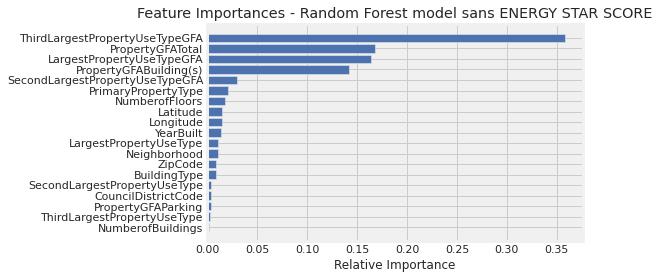

In [199]:
importances = grid_random_STAR.best_estimator_['model'].feature_importances_
indices = np.argsort(importances)
liste_variables = list(X_STAR.columns)

# style du graphique 
plt.style.use('fivethirtyeight')
%matplotlib inline

plt.figure(1)
plt.title('Feature Importances - Random Forest model sans ENERGY STAR SCORE')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [liste_variables[i] for i in indices])
plt.xlabel('Relative Importance')

#### Evaluation de la cross validation

In [180]:
parameters_opt = {
    'model__n_estimators' : [n_estimators_STAR_opt],
    'model__max_features' : [max_features_STAR_opt],
    'model__min_samples_split' : [min_samples_split_STAR_opt],
    'model__max_depth' : [max_depth_STAR_opt]
    }

In [181]:
grid_random_STAR_opt = GridSearchCV(estimator = random_pipe_STAR,
                        param_grid = parameters_opt,
                        scoring='r2',
                        cv=KFold(5, random_state=0, shuffle=True),
                        n_jobs=-1
                          )

In [184]:
grid_random_STAR_opt.fit(X_STAR_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('model',
                                        RandomForestRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [16], 'model__max_features': [0.7],
                         'model__min_samples_split': [3],
                         'model__n_estimators': [8]},
             scoring='r2')

In [185]:
R2_random_STAR = round(grid_random_STAR_opt.best_score_,3)
print(R2_random)

0.857


### Modèle : Gradient Boosting

#### Mise en place du modèle

In [187]:
#Définition des étapes du pipeline

steps = [
    ('scalar', StandardScaler()),  #Standardisation des données d'entrée pour gommer les différences d'échelles
    ('model_boost', GradientBoostingRegressor(random_state = 0))    #Application du modèle = random_forest
]
boost_pipe_STAR = Pipeline(steps) #Création du pipeline

In [188]:
#Entraînement du modèle sur les données d'apprentissage

boost_pipe_STAR.fit(X_STAR_train, y_train)

Pipeline(steps=[('scalar', StandardScaler()),
                ('model_boost', GradientBoostingRegressor(random_state=0))])

In [189]:
parameters = {
    'model_boost__n_estimators' : np.arange(400,500,10),
    'model_boost__learning_rate' : np.arange(0.2,0.4, 0.05),
    'model_boost__min_samples_split' : np.arange(30,40,1),
    'model_boost__max_depth' : np.arange(5,10,1)
}

In [190]:
grid_boost_STAR = GridSearchCV(estimator = boost_pipe_STAR,
                        param_grid = parameters,
                        scoring='neg_root_mean_squared_error',
                        cv=KFold(5, random_state=0, shuffle=True),
                        n_jobs=-1
                          )

In [191]:
grid_boost_STAR.fit(X_STAR_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('model_boost',
                                        GradientBoostingRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model_boost__learning_rate': array([0.2 , 0.25, 0.3 , 0.35]),
                         'model_boost__max_depth': array([5, 6, 7, 8, 9]),
                         'model_boost__min_samples_split': array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39]),
                         'model_boost__n_estimators': array([400, 410, 420, 430, 440, 450, 460, 470, 480, 490])},
             scoring='neg_root_mean_squared_error')

In [194]:
grid_boost_STAR.best_params_

{'model_boost__learning_rate': 0.25,
 'model_boost__max_depth': 7,
 'model_boost__min_samples_split': 34,
 'model_boost__n_estimators': 450}

In [200]:
score_boost_STAR = grid_boost_STAR.best_score_
score_boost_STAR = round(score_boost_STAR)
print(score_boost_STAR)

-4895498


In [201]:
learning_rate_boost_STAR_opt = grid_boost_STAR.best_params_['model_boost__learning_rate']
print(learning_rate_boost_STAR_opt)

0.25


In [202]:
max_depth_boost_STAR_opt = grid_boost_STAR.best_params_['model_boost__max_depth']
print(max_depth_boost_STAR_opt)

7


In [203]:
min_samples_split_boost_STAR_opt = grid_boost_STAR.best_params_['model_boost__min_samples_split']
print(min_samples_split_boost_STAR_opt)

34


In [204]:
n_estimators_boost_STAR_opt = grid_boost_STAR.best_params_['model_boost__n_estimators']
print(n_estimators_boost_STAR_opt)

450


In [205]:
grid_boost_STAR.best_estimator_

Pipeline(steps=[('scalar', StandardScaler()),
                ('model_boost',
                 GradientBoostingRegressor(learning_rate=0.25, max_depth=7,
                                           min_samples_split=34,
                                           n_estimators=450, random_state=0))])

Text(0.5, 0, 'Relative Importance')

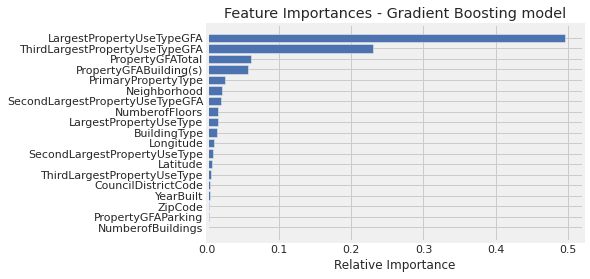

In [206]:
importances = grid_boost_STAR.best_estimator_['model_boost'].feature_importances_
indices = np.argsort(importances)
liste_variables = list(X_STAR.columns)

# style du graphique 
plt.style.use('fivethirtyeight')
%matplotlib inline

plt.figure(1)
plt.title('Feature Importances - Gradient Boosting model')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [liste_variables[i] for i in indices])
plt.xlabel('Relative Importance')

#### Evaluation de la cross validation

In [210]:
parameters_opt = {
    'model_boost__n_estimators' : [n_estimators_boost_STAR_opt],
    'model_boost__learning_rate' : [learning_rate_boost_STAR_opt],
    'model_boost__min_samples_split' : [min_samples_split_boost_STAR_opt],
    'model_boost__max_depth' : [max_depth_boost_STAR_opt]
}

In [211]:
grid_boost_STAR_opt = GridSearchCV(estimator = boost_pipe_STAR,
                        param_grid = parameters_opt,
                        scoring='r2',
                        cv=KFold(5, random_state=0, shuffle=True),
                        n_jobs=-1
                          )

In [212]:
grid_boost_STAR_opt.fit(X_STAR_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('model_boost',
                                        GradientBoostingRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model_boost__learning_rate': [0.25],
                         'model_boost__max_depth': [7],
                         'model_boost__min_samples_split': [34],
                         'model_boost__n_estimators': [450]},
             scoring='r2')

In [213]:
R2_boost_STAR = round(grid_boost_STAR_opt.best_score_,3)
print(R2_boost_STAR)

0.87


## Choix du meilleur modèle

In [215]:
results = pd.DataFrame({
    'Ridge_regression' : [grid_ridge_STAR.best_estimator_, score_ridge_STAR, R2_ridge_STAR],
    'Random Forest' : [grid_random_STAR.best_estimator_, score_random_STAR, R2_random_STAR],
    'Gradient Boosting' : [grid_boost_STAR.best_estimator_, score_boost_STAR, R2_boost_STAR]
}, index = ['Best estimator', 'Grid search error score', 'R2 score'])

In [216]:
results

,Ridge_regression,Random Forest,Gradient Boosting
Best estimator,"(StandardScaler(), Ridge(alpha=1058))","(StandardScaler(), (DecisionTreeRegressor(max_...","(StandardScaler(), ([DecisionTreeRegressor(cri..."
Grid search error score,-9393239,-5300234,-4895498
R2 score,0.475,0.846,0.87


## Prédiction

### Baseline

In [47]:
#Définition des étapes du pipeline

steps = [
    ('scalar', StandardScaler()),  #Standardisation des données d'entrée pour gommer les différences d'échelles
    ('dummy_regr', DummyRegressor(strategy="mean"))    #Application du modèle
]
dummy_regr_pipe = Pipeline(steps) #Création du pipeline

In [53]:
dummy_regr_pipe.fit(X_STAR_train, y_train)

Pipeline(steps=[('scalar', StandardScaler()), ('dummy_regr', DummyRegressor())])

In [54]:
y_pred_dummy = dummy_regr_pipe.predict(X_STAR_test)

In [55]:
print('RMSE_dummy : ', np.sqrt(mean_squared_error(y_test,y_pred_dummy)))
print('R2_Score_dummy : ', r2_score(y_test,y_pred_dummy))

RMSE_dummy :  13106457.56421194
R2_Score_dummy :  -3.6856534348927994e-05


### Meilleur modèle

In [217]:
#Prédictions à partir des données tests

y_pred_boost_STAR = grid_boost_STAR.best_estimator_.predict(X_STAR_test)

RMSE_grid :  4948571.200043767
R2_Score_grid :  0.8574375988609136


/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SiteEnergyUse(kBtu)', ylabel='Density'>

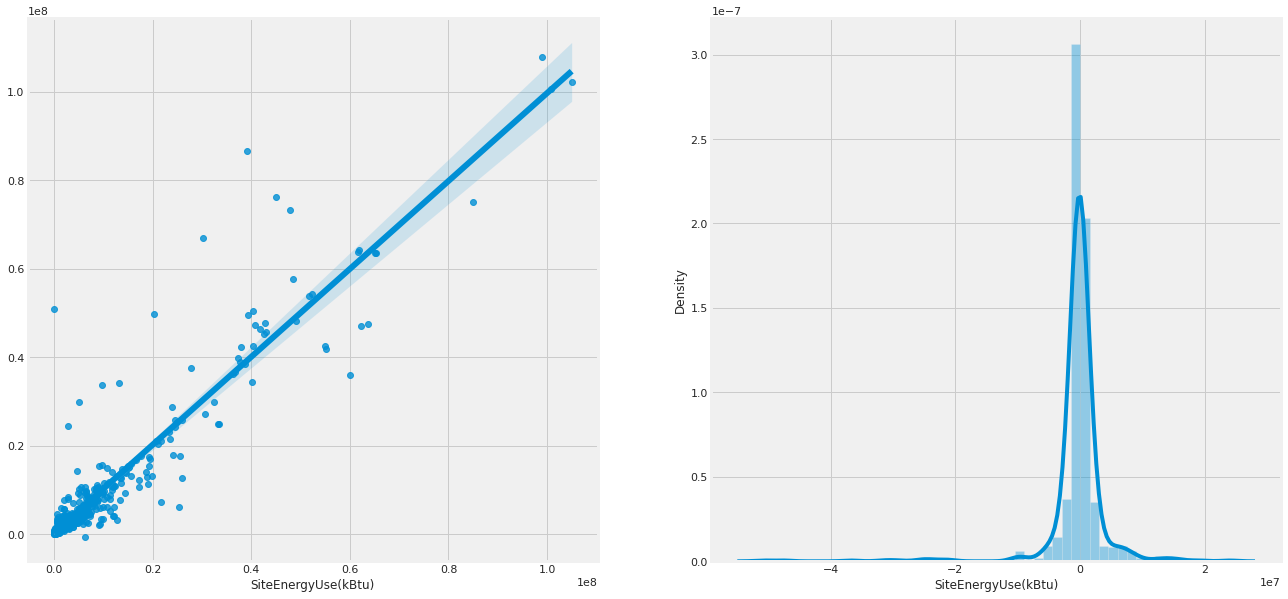

In [218]:
#Evaluation de la prédiction par gradient Boosting

print('RMSE_grid : ', np.sqrt(mean_squared_error(y_test,y_pred_boost_STAR)))
print('R2_Score_grid : ', r2_score(y_test,y_pred_boost_STAR))
f, axes = plt.subplots(1,2,figsize=(20,10))
sns.regplot(x = y_test, y = y_pred_boost_STAR,ax = axes[0])
sns.distplot((y_test-y_pred_boost_STAR),ax = axes[1])

# Essai de mise en place d'un modèle qui conserve toutes les données de la target énergie.

In [56]:
data_tot = pd.read_csv("data_tot_nett.csv")

In [57]:
data_tot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3231 entries, 0 to 3230
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   CouncilDistrictCode              3231 non-null   int64  
 1   YearBuilt                        3231 non-null   float64
 2   NumberofBuildings                3231 non-null   float64
 3   NumberofFloors                   3231 non-null   float64
 4   PropertyGFATotal                 3231 non-null   float64
 5   PropertyGFAParking               3231 non-null   float64
 6   PropertyGFABuilding(s)           3231 non-null   float64
 7   LargestPropertyUseTypeGFA        3231 non-null   float64
 8   SecondLargestPropertyUseTypeGFA  3231 non-null   float64
 9   ThirdLargestPropertyUseTypeGFA   3231 non-null   float64
 10  ENERGYSTARScore                  3231 non-null   float64
 11  SiteEnergyUse(kBtu)              3231 non-null   float64
 12  TotalGHGEmissions   

In [58]:
data_tot.isna().mean()

CouncilDistrictCode                0.000000
YearBuilt                          0.000000
NumberofBuildings                  0.000000
NumberofFloors                     0.000000
PropertyGFATotal                   0.000000
PropertyGFAParking                 0.000000
PropertyGFABuilding(s)             0.000000
LargestPropertyUseTypeGFA          0.000000
SecondLargestPropertyUseTypeGFA    0.000000
ThirdLargestPropertyUseTypeGFA     0.000000
ENERGYSTARScore                    0.000000
SiteEnergyUse(kBtu)                0.000000
TotalGHGEmissions                  0.000000
ZipCode                            0.000000
Latitude                           0.000000
Longitude                          0.000000
BuildingType                       0.000000
PrimaryPropertyType                0.000000
Neighborhood                       0.000000
LargestPropertyUseType             0.021975
SecondLargestPropertyUseType       0.493036
ThirdLargestPropertyUseType        0.790158
dtype: float64

In [59]:
data_tot['LargestPropertyUseType'] = data_tot['LargestPropertyUseType'].astype(str)
data_tot['SecondLargestPropertyUseType'] = data_tot['SecondLargestPropertyUseType'].astype(str)
data_tot['ThirdLargestPropertyUseType'] = data_tot['ThirdLargestPropertyUseType'].astype(str)

In [60]:
data_tot.isna().mean()

CouncilDistrictCode                0.0
YearBuilt                          0.0
NumberofBuildings                  0.0
NumberofFloors                     0.0
PropertyGFATotal                   0.0
PropertyGFAParking                 0.0
PropertyGFABuilding(s)             0.0
LargestPropertyUseTypeGFA          0.0
SecondLargestPropertyUseTypeGFA    0.0
ThirdLargestPropertyUseTypeGFA     0.0
ENERGYSTARScore                    0.0
SiteEnergyUse(kBtu)                0.0
TotalGHGEmissions                  0.0
ZipCode                            0.0
Latitude                           0.0
Longitude                          0.0
BuildingType                       0.0
PrimaryPropertyType                0.0
Neighborhood                       0.0
LargestPropertyUseType             0.0
SecondLargestPropertyUseType       0.0
ThirdLargestPropertyUseType        0.0
dtype: float64

In [61]:
print(data_tot.shape)
data_tot = data_tot.drop(['TotalGHGEmissions'], axis=1)
print(data_tot.shape)

(3231, 22)
(3231, 21)


<AxesSubplot:>

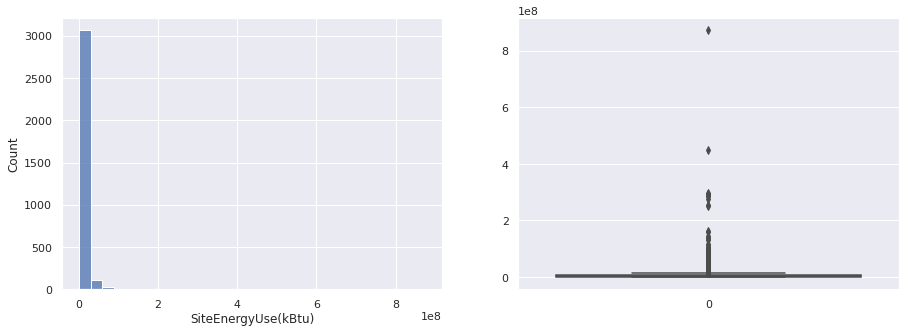

In [62]:
#Pour rappel : Histogramme de distribution et boxplot'

var = 'SiteEnergyUse(kBtu)'

sns.set(rc = {'figure.figsize':(15,5)})
fig, (ax1, ax2) = plt.subplots(1,2)
sns.histplot(data_tot, x=var, bins=30, ax=ax1)
sns.boxplot(data = data_tot[var], ax=ax2)

In [64]:
data_tot['SiteEnergyUse(kBtu)'].describe()

count    3.231000e+03
mean     8.128023e+06
std      2.550981e+07
min      0.000000e+00
25%      1.243047e+06
50%      2.553764e+06
75%      6.926601e+06
max      8.739237e+08
Name: SiteEnergyUse(kBtu), dtype: float64

In [69]:
data_tot['SiteEnergyUse(kBtu)_log'] = [log(energy+1) for energy in data_tot['SiteEnergyUse(kBtu)']]

In [72]:
data_tot.shape

(3231, 22)

In [73]:
data_tot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3231 entries, 0 to 3230
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   CouncilDistrictCode              3231 non-null   int64  
 1   YearBuilt                        3231 non-null   float64
 2   NumberofBuildings                3231 non-null   float64
 3   NumberofFloors                   3231 non-null   float64
 4   PropertyGFATotal                 3231 non-null   float64
 5   PropertyGFAParking               3231 non-null   float64
 6   PropertyGFABuilding(s)           3231 non-null   float64
 7   LargestPropertyUseTypeGFA        3231 non-null   float64
 8   SecondLargestPropertyUseTypeGFA  3231 non-null   float64
 9   ThirdLargestPropertyUseTypeGFA   3231 non-null   float64
 10  ENERGYSTARScore                  3231 non-null   float64
 11  SiteEnergyUse(kBtu)              3231 non-null   float64
 12  ZipCode             

<AxesSubplot:>

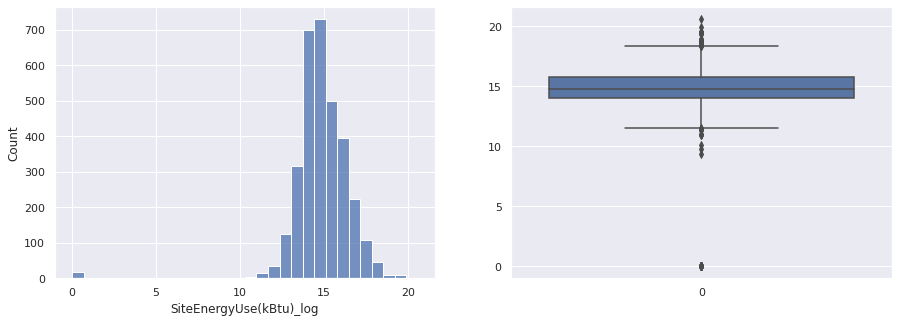

In [74]:
#Pour rappel : Histogramme de distribution et boxplot'

var = 'SiteEnergyUse(kBtu)_log'

sns.set(rc = {'figure.figsize':(15,5)})
fig, (ax1, ax2) = plt.subplots(1,2)
sns.histplot(data_tot, x=var, bins=30, ax=ax1)
sns.boxplot(data = data_tot[var], ax=ax2)

In [75]:
data_tot['SiteEnergyUse(kBtu)_log'].describe()

count    3231.000000
mean       14.838850
std         1.708809
min         0.000000
25%        14.033077
50%        14.753079
75%        15.750879
max        20.588504
Name: SiteEnergyUse(kBtu)_log, dtype: float64

In [76]:
print(data_tot.shape)
data_tot = data_tot.drop(['SiteEnergyUse(kBtu)'], axis=1)
print(data_tot.shape)

(3231, 22)
(3231, 21)


In [78]:
#Définition des variables X et de la target y

X = data_tot.drop(['SiteEnergyUse(kBtu)_log'], axis=1)
y = data_tot['SiteEnergyUse(kBtu)_log']

In [79]:
print(X.shape)
print(y.shape)

(3231, 20)
(3231,)


In [80]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3231 entries, 0 to 3230
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   CouncilDistrictCode              3231 non-null   int64  
 1   YearBuilt                        3231 non-null   float64
 2   NumberofBuildings                3231 non-null   float64
 3   NumberofFloors                   3231 non-null   float64
 4   PropertyGFATotal                 3231 non-null   float64
 5   PropertyGFAParking               3231 non-null   float64
 6   PropertyGFABuilding(s)           3231 non-null   float64
 7   LargestPropertyUseTypeGFA        3231 non-null   float64
 8   SecondLargestPropertyUseTypeGFA  3231 non-null   float64
 9   ThirdLargestPropertyUseTypeGFA   3231 non-null   float64
 10  ENERGYSTARScore                  3231 non-null   float64
 11  ZipCode                          3231 non-null   int64  
 12  Latitude            

In [81]:
#Encodage des variables qualitatives

encoder = LabelEncoder()

X['BuildingType'] = encoder.fit_transform(X['BuildingType'])
X['PrimaryPropertyType'] = encoder.fit_transform(X['PrimaryPropertyType'])
X['Neighborhood'] = encoder.fit_transform(X['Neighborhood'])
X['LargestPropertyUseType'] = encoder.fit_transform(X['LargestPropertyUseType'])
X['SecondLargestPropertyUseType'] = encoder.fit_transform(X['SecondLargestPropertyUseType'])
X['ThirdLargestPropertyUseType'] = encoder.fit_transform(X['ThirdLargestPropertyUseType'])

In [82]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3231 entries, 0 to 3230
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   CouncilDistrictCode              3231 non-null   int64  
 1   YearBuilt                        3231 non-null   float64
 2   NumberofBuildings                3231 non-null   float64
 3   NumberofFloors                   3231 non-null   float64
 4   PropertyGFATotal                 3231 non-null   float64
 5   PropertyGFAParking               3231 non-null   float64
 6   PropertyGFABuilding(s)           3231 non-null   float64
 7   LargestPropertyUseTypeGFA        3231 non-null   float64
 8   SecondLargestPropertyUseTypeGFA  3231 non-null   float64
 9   ThirdLargestPropertyUseTypeGFA   3231 non-null   float64
 10  ENERGYSTARScore                  3231 non-null   float64
 11  ZipCode                          3231 non-null   int64  
 12  Latitude            

In [83]:
#Constitution des jeux de données test et train

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2584, 20)
(2584,)
(647, 20)
(647,)


### Ridge Regression

#### Mise en place du modèle 

In [84]:
#Définition des étapes du pipeline

steps = [
    ('scalar', StandardScaler()),  #Standardisation des données d'entrée pour gommer les différences d'échelles
    ('model', Ridge())    #Application du modèle = Regression Ridge
]
ridge_pipe = Pipeline(steps) #Création du pipeline

In [85]:
#Entraînement du modèle sur les données d'apprentissage

ridge_pipe.fit(X_train, y_train)

Pipeline(steps=[('scalar', StandardScaler()), ('model', Ridge())])

#### Optimisation de l'hyperparamètre alpha

In [92]:
#Optimisation de l'hyperparamètre alpha par Grid search sur les données d'apprentissage

parameters = {'model__alpha': np.arange(0, 1000, 1)} #Je définie l'étendue de la grille pour les valeurs d'alpha
 
grid_ridge = GridSearchCV(estimator = ridge_pipe, #Optimisation automatique des paramètres selon la grille définie
                           param_grid = parameters,
                           scoring = 'neg_root_mean_squared_error',
                           cv = KFold(5, random_state=0, shuffle=True),
                           n_jobs = -1)
grid_ridge = grid_ridge.fit(X_train, y_train)

In [94]:
#Meilleure valeur pour alpha
alpha_opt = grid_ridge.best_params_['model__alpha']
print(alpha_opt)

372


In [97]:
#Valeur de score la plus basse
score_ridge = grid_ridge.best_score_
score_ridge = round(score_ridge,3)
print(score_ridge)

-1.405


In [98]:
#Meilleur modèle
grid_ridge.best_estimator_

Pipeline(steps=[('scalar', StandardScaler()), ('model', Ridge(alpha=372))])

#### Evaluation de la cross validation

In [99]:
#Relance de la Grid Search en cross validation avec l'alpha optimal et le R2 score

parameters = {'model__alpha': [alpha_opt] }
 
grid_ridge_opt = GridSearchCV(estimator = ridge_pipe,
                           param_grid = parameters,
                           scoring = 'r2',
                           cv = KFold(5, random_state=0, shuffle=True),
                           n_jobs = -1)
grid_ridge_opt = grid_ridge_opt.fit(X_train, y_train)

In [100]:
#Valeur du R2
R2_ridge = round(grid_ridge_opt.best_score_,3)
print(R2_ridge)

0.303


### Modèle : Random Forest

#### Mise en place du modèle

In [101]:
#Définition des étapes du pipeline

steps = [
    ('scalar', StandardScaler()),  #Standardisation des données d'entrée pour gommer les différences d'échelles
    ('model', RandomForestRegressor(random_state = 0))    #Application du modèle = random_forest
]
random_pipe = Pipeline(steps) #Création du pipeline

In [102]:
#Entraînement du modèle sur les données d'apprentissage

random_pipe.fit(X_train, y_train)

Pipeline(steps=[('scalar', StandardScaler()),
                ('model', RandomForestRegressor(random_state=0))])

#### Optimisation des hyperparamètres

In [103]:
parameters = {
    'model__n_estimators' : np.arange(1,100,10),
    'model__max_features' : np.arange(0.1,0.9, 0.1),
    'model__min_samples_split' : np.arange(1,10,1),
    'model__max_depth' : np.arange(1,20,2)
    }

In [104]:
grid_random = GridSearchCV(estimator = random_pipe,
                        param_grid = parameters,
                        scoring='neg_root_mean_squared_error',
                        cv=KFold(5, random_state=0, shuffle=True),
                        n_jobs=-1
                          )

In [105]:
grid_random.fit(X_train,y_train)

/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
4000 fits failed out of a total of 36000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4000 fits failed with the following error:
Traceback (most recent call last):
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/ensem

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('model',
                                        RandomForestRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model__max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                         'model__max_features': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                         'model__min_samples_split': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'model__n_estimators': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91])},
             scoring='neg_root_mean_squared_error')

In [106]:
grid_random.best_params_

{'model__max_depth': 19,
 'model__max_features': 0.4,
 'model__min_samples_split': 3,
 'model__n_estimators': 11}

In [108]:
score_random = grid_random.best_score_
score_random = round(score_random,3)
print(score_random)

-0.704


In [109]:
parameters = {
    'model__n_estimators' : np.arange(1,30,1),
    'model__max_features' : np.arange(0.1,0.6, 0.1),
    'model__min_samples_split' : np.arange(1,5,1),
    'model__max_depth' : np.arange(15,50,1)
    }

In [110]:
grid_random = GridSearchCV(estimator = random_pipe,
                        param_grid = parameters,
                        scoring='neg_root_mean_squared_error',
                        cv=KFold(5, random_state=0, shuffle=True),
                        n_jobs=-1
                          )

In [111]:
grid_random.fit(X_train,y_train)

/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
25375 fits failed out of a total of 101500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25375 fits failed with the following error:
Traceback (most recent call last):
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/en

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('model',
                                        RandomForestRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model__max_depth': array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
       32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
       49]),
                         'model__max_features': array([0.1, 0.2, 0.3, 0.4, 0.5]),
                         'model__min_samples_split': array([1, 2, 3, 4]),
                         'model__n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])},
             scoring='neg_root_mean_squared_error')

In [113]:
grid_random.best_params_

{'model__max_depth': 19,
 'model__max_features': 0.4,
 'model__min_samples_split': 3,
 'model__n_estimators': 12}

In [114]:
score_random = grid_random.best_score_
score_random = round(score_random,3)
print(score_random)

-0.699


In [ ]:
Les paramètres sont optimaux

In [115]:
max_depth_opt = grid_random.best_params_['model__max_depth']
print(max_depth_opt)

19


In [116]:
max_features_opt = grid_random.best_params_['model__max_features']
print(max_features_opt)

0.4


In [117]:
min_samples_split_opt = grid_random.best_params_['model__min_samples_split']
print(min_samples_split_opt)

3


In [118]:
n_estimators_opt = grid_random.best_params_['model__n_estimators']
print(n_estimators_opt)

12


In [119]:
grid_random.best_estimator_

Pipeline(steps=[('scalar', StandardScaler()),
                ('model',
                 RandomForestRegressor(max_depth=19, max_features=0.4,
                                       min_samples_split=3, n_estimators=12,
                                       random_state=0))])

Text(0.5, 0, 'Relative Importance')

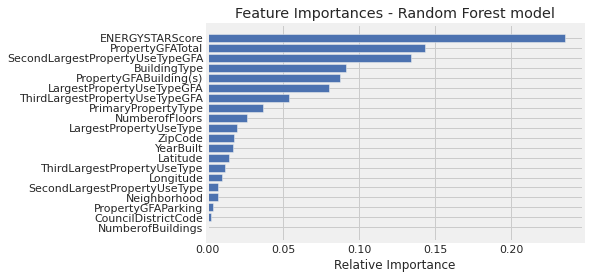

In [120]:
importances = grid_random.best_estimator_['model'].feature_importances_
indices = np.argsort(importances)
liste_variables = list(X.columns)

# style du graphique 
plt.style.use('fivethirtyeight')
%matplotlib inline

plt.figure(1)
plt.title('Feature Importances - Random Forest model')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [liste_variables[i] for i in indices])
plt.xlabel('Relative Importance')

#### Evaluation de la cross validation

In [121]:
parameters_opt = {
    'model__n_estimators' : [n_estimators_opt],
    'model__max_features' : [max_features_opt],
    'model__min_samples_split' : [min_samples_split_opt],
    'model__max_depth' : [max_depth_opt]
    }

In [122]:
grid_random_opt = GridSearchCV(estimator = random_pipe,
                        param_grid = parameters_opt,
                        scoring='r2',
                        cv=KFold(5, random_state=0, shuffle=True),
                        n_jobs=-1
                          )

In [123]:
grid_random_opt.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('model',
                                        RandomForestRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [19], 'model__max_features': [0.4],
                         'model__min_samples_split': [3],
                         'model__n_estimators': [12]},
             scoring='r2')

In [124]:
R2_random = round(grid_random_opt.best_score_,3)
print(R2_random)

0.82


In [127]:
results = pd.DataFrame({
    'Ridge_regression log' : [score_ridge, R2_ridge],
    'Random Forest log' : [score_random, R2_random],
}, index = ['Grid search error score', 'R2 score'])

In [128]:
results

,Ridge_regression log,Random Forest log
Grid search error score,-1.405,-0.699
R2 score,0.303,0.820


In [129]:
data_tot = pd.read_csv("data_tot_nett.csv")

In [131]:
data_tot['LargestPropertyUseType'] = data_tot['LargestPropertyUseType'].astype(str)
data_tot['SecondLargestPropertyUseType'] = data_tot['SecondLargestPropertyUseType'].astype(str)
data_tot['ThirdLargestPropertyUseType'] = data_tot['ThirdLargestPropertyUseType'].astype(str)

In [132]:
data_tot.isna().mean()

CouncilDistrictCode                0.0
YearBuilt                          0.0
NumberofBuildings                  0.0
NumberofFloors                     0.0
PropertyGFATotal                   0.0
PropertyGFAParking                 0.0
PropertyGFABuilding(s)             0.0
LargestPropertyUseTypeGFA          0.0
SecondLargestPropertyUseTypeGFA    0.0
ThirdLargestPropertyUseTypeGFA     0.0
ENERGYSTARScore                    0.0
SiteEnergyUse(kBtu)                0.0
TotalGHGEmissions                  0.0
ZipCode                            0.0
Latitude                           0.0
Longitude                          0.0
BuildingType                       0.0
PrimaryPropertyType                0.0
Neighborhood                       0.0
LargestPropertyUseType             0.0
SecondLargestPropertyUseType       0.0
ThirdLargestPropertyUseType        0.0
dtype: float64

In [133]:
print(data_tot.shape)
data_tot = data_tot.drop(['TotalGHGEmissions'], axis=1)
print(data_tot.shape)

(3231, 22)
(3231, 21)


In [134]:
#Définition des variables X et de la target y

X = data_tot.drop(['SiteEnergyUse(kBtu)'], axis=1)
y = data_tot['SiteEnergyUse(kBtu)']

In [135]:
print(X.shape)
print(y.shape)

(3231, 20)
(3231,)


In [136]:
#Encodage des variables qualitatives

encoder = LabelEncoder()

X['BuildingType'] = encoder.fit_transform(X['BuildingType'])
X['PrimaryPropertyType'] = encoder.fit_transform(X['PrimaryPropertyType'])
X['Neighborhood'] = encoder.fit_transform(X['Neighborhood'])
X['LargestPropertyUseType'] = encoder.fit_transform(X['LargestPropertyUseType'])
X['SecondLargestPropertyUseType'] = encoder.fit_transform(X['SecondLargestPropertyUseType'])
X['ThirdLargestPropertyUseType'] = encoder.fit_transform(X['ThirdLargestPropertyUseType'])

In [137]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3231 entries, 0 to 3230
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   CouncilDistrictCode              3231 non-null   int64  
 1   YearBuilt                        3231 non-null   float64
 2   NumberofBuildings                3231 non-null   float64
 3   NumberofFloors                   3231 non-null   float64
 4   PropertyGFATotal                 3231 non-null   float64
 5   PropertyGFAParking               3231 non-null   float64
 6   PropertyGFABuilding(s)           3231 non-null   float64
 7   LargestPropertyUseTypeGFA        3231 non-null   float64
 8   SecondLargestPropertyUseTypeGFA  3231 non-null   float64
 9   ThirdLargestPropertyUseTypeGFA   3231 non-null   float64
 10  ENERGYSTARScore                  3231 non-null   float64
 11  ZipCode                          3231 non-null   int64  
 12  Latitude            

In [138]:
#Constitution des jeux de données test et train

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2584, 20)
(2584,)
(647, 20)
(647,)


### Ridge Regression

#### Mise en place du modèle 

In [139]:
#Définition des étapes du pipeline

steps = [
    ('scalar', StandardScaler()),  #Standardisation des données d'entrée pour gommer les différences d'échelles
    ('model', Ridge())    #Application du modèle = Regression Ridge
]
ridge_pipe = Pipeline(steps) #Création du pipeline

In [140]:
#Entraînement du modèle sur les données d'apprentissage

ridge_pipe.fit(X_train, y_train)

Pipeline(steps=[('scalar', StandardScaler()), ('model', Ridge())])

#### Optimisation de l'hyperparamètre alpha

In [141]:
#Optimisation de l'hyperparamètre alpha par Grid search sur les données d'apprentissage

parameters = {'model__alpha': np.arange(0, 1000, 1)} #Je définie l'étendue de la grille pour les valeurs d'alpha
 
grid_ridge = GridSearchCV(estimator = ridge_pipe, #Optimisation automatique des paramètres selon la grille définie
                           param_grid = parameters,
                           scoring = 'neg_root_mean_squared_error',
                           cv = KFold(5, random_state=0, shuffle=True),
                           n_jobs = -1)
grid_ridge = grid_ridge.fit(X_train, y_train)

In [142]:
#Meilleure valeur pour alpha
alpha_opt = grid_ridge.best_params_['model__alpha']
print(alpha_opt)

1


In [143]:
#Valeur de score la plus basse
score_ridge = grid_ridge.best_score_
score_ridge = round(score_ridge,3)
print(score_ridge)

-12112449.165


In [144]:
#Meilleur modèle
grid_ridge.best_estimator_

Pipeline(steps=[('scalar', StandardScaler()), ('model', Ridge(alpha=1))])

#### Evaluation de la cross validation

In [145]:
#Relance de la Grid Search en cross validation avec l'alpha optimal et le R2 score

parameters = {'model__alpha': [alpha_opt] }
 
grid_ridge_opt = GridSearchCV(estimator = ridge_pipe,
                           param_grid = parameters,
                           scoring = 'r2',
                           cv = KFold(5, random_state=0, shuffle=True),
                           n_jobs = -1)
grid_ridge_opt = grid_ridge_opt.fit(X_train, y_train)

In [146]:
#Valeur du R2
R2_ridge = round(grid_ridge_opt.best_score_,3)
print(R2_ridge)

0.622


### Modèle : Random Forest

#### Mise en place du modèle

In [147]:
#Définition des étapes du pipeline

steps = [
    ('scalar', StandardScaler()),  #Standardisation des données d'entrée pour gommer les différences d'échelles
    ('model', RandomForestRegressor(random_state = 0))    #Application du modèle = random_forest
]
random_pipe = Pipeline(steps) #Création du pipeline

In [148]:
#Entraînement du modèle sur les données d'apprentissage

random_pipe.fit(X_train, y_train)

Pipeline(steps=[('scalar', StandardScaler()),
                ('model', RandomForestRegressor(random_state=0))])

#### Optimisation des hyperparamètres

In [150]:
parameters = {
    'model__n_estimators' : np.arange(1,100,10),
    'model__max_features' : np.arange(0.1,0.9, 0.1),
    'model__min_samples_split' : np.arange(1,10,1),
    'model__max_depth' : np.arange(1,50,2)
    }

In [151]:
grid_random = GridSearchCV(estimator = random_pipe,
                        param_grid = parameters,
                        scoring='neg_root_mean_squared_error',
                        cv=KFold(5, random_state=0, shuffle=True),
                        n_jobs=-1
                          )

In [152]:
grid_random.fit(X_train,y_train)

/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10000 fits failed out of a total of 90000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10000 fits failed with the following error:
Traceback (most recent call last):
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/ens

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('model',
                                        RandomForestRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model__max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49]),
                         'model__max_features': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                         'model__min_samples_split': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'model__n_estimators': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91])},
             scoring='neg_root_mean_squared_error')

In [153]:
grid_random.best_params_

{'model__max_depth': 19,
 'model__max_features': 0.6,
 'model__min_samples_split': 2,
 'model__n_estimators': 11}

In [154]:
score_random = grid_random.best_score_
score_random = round(score_random,3)
print(score_random)

-12203983.01


In [155]:
max_depth_opt = grid_random.best_params_['model__max_depth']
print(max_depth_opt)

19


In [156]:
max_features_opt = grid_random.best_params_['model__max_features']
print(max_features_opt)

0.6


In [157]:
min_samples_split_opt = grid_random.best_params_['model__min_samples_split']
print(min_samples_split_opt)

2


In [158]:
n_estimators_opt = grid_random.best_params_['model__n_estimators']
print(n_estimators_opt)

11


In [159]:
grid_random.best_estimator_

Pipeline(steps=[('scalar', StandardScaler()),
                ('model',
                 RandomForestRegressor(max_depth=19, max_features=0.6,
                                       n_estimators=11, random_state=0))])

Text(0.5, 0, 'Relative Importance')

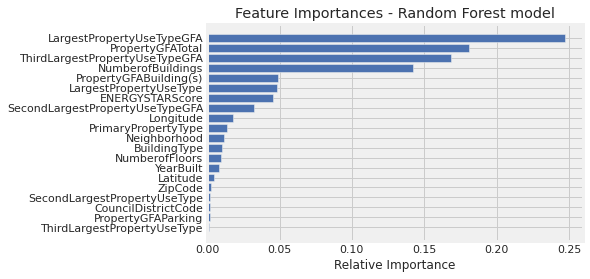

In [160]:
importances = grid_random.best_estimator_['model'].feature_importances_
indices = np.argsort(importances)
liste_variables = list(X.columns)

# style du graphique 
plt.style.use('fivethirtyeight')
%matplotlib inline

plt.figure(1)
plt.title('Feature Importances - Random Forest model')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [liste_variables[i] for i in indices])
plt.xlabel('Relative Importance')

#### Evaluation de la cross validation

In [161]:
parameters_opt = {
    'model__n_estimators' : [n_estimators_opt],
    'model__max_features' : [max_features_opt],
    'model__min_samples_split' : [min_samples_split_opt],
    'model__max_depth' : [max_depth_opt]
    }

In [162]:
grid_random_opt = GridSearchCV(estimator = random_pipe,
                        param_grid = parameters_opt,
                        scoring='r2',
                        cv=KFold(5, random_state=0, shuffle=True),
                        n_jobs=-1
                          )

In [163]:
grid_random_opt.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('model',
                                        RandomForestRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [19], 'model__max_features': [0.6],
                         'model__min_samples_split': [2],
                         'model__n_estimators': [11]},
             scoring='r2')

In [164]:
R2_random = round(grid_random_opt.best_score_,3)
print(R2_random)

0.74


In [165]:
results = pd.DataFrame({
    'Ridge_regression tot' : [score_ridge, R2_ridge],
    'Random Forest tot' : [score_random, R2_random],
}, index = ['Grid search error score', 'R2 score'])

In [166]:
results

,Ridge_regression tot,Random Forest tot
Grid search error score,-1.211245e+07,-12203983.01
R2 score,6.220000e-01,0.74
